# DEM-GNN Rollout Evaluation

## Import dependencies

In [1]:
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm, trange

torch.cuda.is_available()
np.set_printoptions(linewidth=200)
torch.set_printoptions(linewidth=200)

In [ ]:
from ML_functions import MaskTestData
[data, top, bc] = MaskTestData("2Sphere","test")

In [ ]:
from ML_functions import Rescale
data_0 = data[0]
bundle_size = 3
push_forward_steps = 5
t=0
print(data_0.shape)

np.set_printoptions(suppress=True)
par_data = data_0

pos_slice = par_data[t+push_forward_steps*bundle_size:t+(push_forward_steps+1)*bundle_size,:,:3]
pos_target_slice = par_data[t+1+push_forward_steps*bundle_size:t+1+(push_forward_steps+1)*bundle_size,:,:3]
displacements = pos_target_slice-pos_slice
print(f"{displacements},",displacements.shape,"\n")
displacements = np.reshape(np.swapaxes(displacements,0,1),(-1,3*bundle_size)).astype(float)

reshaped = np.split(displacements,displacements.shape[1]/3,axis=1)
reshaped = np.stack(reshaped)
print(f"{reshaped},",reshaped.shape,"\n")

In [ ]:
par_data = data[0]
bundle_size = 3
push_forward_steps = 5
t=0




pos_slice        = SliceAndReshapeData(par_data,t,  bundle_size,push_forward_steps)
pos_target_slice = SliceAndReshapeData(par_data,t+1,bundle_size,push_forward_steps)
displacements = pos_target_slice-pos_slice

print(f"{displacements},",displacements.shape,"\n")
np.set_printoptions(suppress=True)

## Loading and training on datasets

In [3]:
from ML_functions import DEM_Dataset, Trainer, GetModel
dataset_name="2Sphere"
model_ident = "BundleTest"
model_name=f"{dataset_name}_{model_ident}"
pre_transform = T.Compose([T.Cartesian(False),
                           T.Distance(norm=False,cat=True)])
transform       = None
force_reload    = True
train           = False

[dataset_train, dataset_val, dataset_test] = [DEM_Dataset(dataset_name,
                                                        dataset_type,
                                                        force_reload     = force_reload,
                                                        pre_transform    = pre_transform,
                                                        bundle_size=3) 
                                                        for dataset_type in ["train","validate","test"]]
[dataset_train_push]  = [DEM_Dataset(dataset_name,
                                    dataset_type,
                                    force_reload     = force_reload,
                                    pre_transform    = pre_transform,
                                    push_forward_step_max=3,
                                    model = GetModel(model_name)[0]) 
                                    for dataset_type in ["train"]]

if train == True:
    model = GetModel(dataset_name,model_ident,edge_dim=4)
    trainer = Trainer(model, dataset_train,dataset_val,
                      batch_size=32,
                      lr=0.0000001,
                      epochs=2000,
                      model_name=f"{dataset_name}{model_ident}")
    #trainer.train_loop()

Processing...


100%|██████████| 1700/1700 [01:19<00:00, 21.45it/s]


Pre-processing train data


 22%|██▏       | 36066/164900 [00:05<00:17, 7207.97it/s]


KeyboardInterrupt: 

In [ ]:
dataset_test[0].y

In [ ]:
from Plotting import PlotTrainingLoss
dataset_name="N400_Mono"
model_ident = "NewModel_2_Push"
try: fig, axs = PlotTrainingLoss(dataset_name,model_ident)
except: print("Failed plot")

## Generating Rollouts

In [ ]:
from ML_functions import NormalizeData, MaskTestData
from Evaluation import Evaluate
dataset_name="N400_Mono"
transform = T.Compose([T.Cartesian(False),T.Distance(norm=False,cat=True),NormalizeData(dataset_name)])
AggregatedArgs = MaskTestData(dataset_name,"test")
metrics = Evaluate(dataset_name,"NewModel_1",transform, AggregatedArgs)
metrics = Evaluate(dataset_name,"NewModel_2",transform, AggregatedArgs)
metrics = Evaluate(dataset_name,"NewModel_2_Push",transform, AggregatedArgs)

In [ ]:
metrics = Evaluate("2Sphere","NewModel_1",transform)
metrics = Evaluate("2Sphere","NewModel_2",transform)
metrics = Evaluate("2Sphere","NewModel_2_Push",transform)

In [4]:
from Plotting import PlotXYZ
from ML_functions import LearnedSimulator, NormalizeData, GetModel, Rescale, NormalizePos, MaskTestData

dataset_name="2Sphere"
model_ident = "Bundletest"

model_name = f"{dataset_name}_{model_ident}"
model = GetModel(model_name)[0]
AggregatedArgs = MaskTestData(dataset_name,"test")

Loaded model 2Sphere_Bundletest


Calculating BC


100%|██████████| 100/100 [00:00<00:00, 99911.96it/s]


100%|██████████| 100/100 [00:00<00:00, 1960.82it/s]


Calculating Learned Rollout


34it [00:00, 87.09it/s]                        


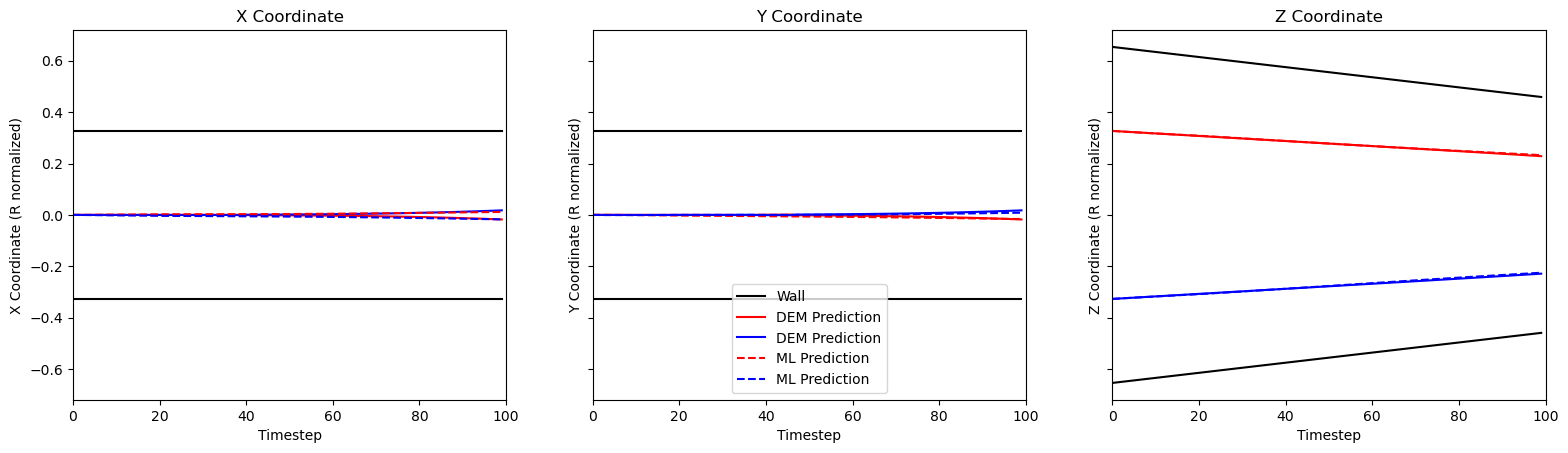

In [ ]:
transform = T.Compose([T.Cartesian(False),T.Distance(norm=False,cat=True),NormalizeData(dataset_name)])
Simulation = LearnedSimulator(model, scale_function = Rescale(dataset_name),transform = transform)
for sample_idx in [0]:
    Simulation.Rollout(*AggregatedArgs,sample_idx,show_tqdm=True)
    if dataset_name == "2Sphere": 
        PlotXYZ(Simulation,t_max=100, normalize=False)

In [9]:
len(Simulation.ML_rollout)

298

## Evaluating Rollouts

In [ ]:
from Plotting import PlotGraphComparison
save = False
show = True
for t in range(0,100,5):  
    fig = PlotGraphComparison(t,Simulation,sample_idx,Simulation.tol,plot_lines=True)
    if save == True: plt.savefig(f"{os.getcwd()}\\Figures\\Plots\\Graph_Sample{sample_idx}_Time{t}_Tol{str(Simulation.tol)[2:]}.png",bbox_inches='tight')     
    if show == True: plt.show()

In [ ]:
from Plotting import PlotFres
from Evaluation import AggregateForces
Fcontact_GT,Fres_GT, Fnorm_GT, Fsum_GT = AggregateForces(Simulation.GroundTruth)
Fcontact_ML,Fres_ML, Fnorm_ML, Fsum_ML = AggregateForces(Simulation.ML_rollout)
fig = PlotFres(Fsum_GT,Fsum_ML)

In [ ]:
from Plotting import PlotStressComparison
fig, axs = PlotStressComparison(Simulation,Fcontact_GT,Fcontact_ML,Plot_ML=True)

In [ ]:
from Plotting import PlotForceDistributionComparison
quantiles = [1,5,10,25,50]
fig, ax = PlotForceDistributionComparison(Fnorm_GT,Fnorm_ML,quantiles,True)

In [ ]:
import pyvista as pv
from Plotting import MakeGIF, PlotMeshNormals


#datalist = Rollout.ML_rollout
#gifname = f"ML_2_{sample_idx}_Tol{str(tol)[2:]}"
gifname = f"{dataset_name}_{model_ident}_deform"
datalist = Simulation.GroundTruth
#datalist = Rollout.ML_rollout
MakeGIF(datalist,gifname,fps=8,color='lightblue',deformation=True)

#data = Rollout.ML_rollout[10]
#data = Rollout.GroundTruth[0]
#PlotMeshNormals(data)


## Testing New Code

### Benchmarking topology functions

In [ ]:
from Encoding import ConstructTopology
from ML_functions import MaskTestData
dataset_name = 'N400'
AggregatedArgs = MaskTestData(dataset_name,'test')
data,top,bc = AggregatedArgs
data = data[0]
top = top[0]
bc = bc[0]
t=0
BC_t = bc.copy()
BC_t[:,:3] = bc[:,:3]+(t+1)*bc[:,-3:]


par_data = data[0]
super_topology = ConstructTopology(par_data,BC_t,6)-1

In [ ]:
from Encoding import TopologyFromPlausibleTopology_old, TopologyFromPlausibleTopology

tol=0
t0 = time.time()
topology_0 = ConstructTopology(par_data,BC_t,tol)-1
t1 = time.time()
topology_1 = TopologyFromPlausibleTopology_old(super_topology,par_data,BC_t,tol)
t2 = time.time()
topology_2 = TopologyFromPlausibleTopology(super_topology,par_data,BC_t,tol)
t3 = time.time()

print(np.all(topology_0 == topology_1))
print(np.all(topology_1 == topology_2))
print(t1-t0)
print(t2-t1)
print(t3-t2)

In [ ]:
AggregatedArgs = MaskTestData(dataset_name)
data,top,bc = AggregatedArgs
par_data = data[0][0]
print(par_data)
R_avg = par_data[0,3]
noise_factor = 0.01
standard_deviation = noise_factor*R_avg
noise = np.array(standard_deviation*torch.randn((par_data.shape[0],3)))
par_data[:,:3]+=noise
print(par_data)

In [ ]:
t=40
BC_t = bc.copy()
BC_t[:,:3] = bc[:,:3]+(t+1)*bc[:,-3:]
bc=BC_t
par_data = data[t]
top0 = ConstructTopology(par_data,bc,0)-1

from Encoding import TopologyFromPlausibleTopology
topology_sub = TopologyFromPlausibleTopology(super_topology,par_data,BC_t,0)

topology_sub == top0,topology_sub

In [ ]:
from Evaluation import GetGamma
gamma = GetGamma(data)
gamma

### Testing normalization

In [ ]:
def AverageDX(data):
    norm = torch.norm(data.y,dim=1)
    return torch.mean(norm)

dataset_test.y.abs().mean().item()

In [ ]:
def PrintDatasetStats(dataset):
    torch.set_printoptions(sci_mode=False, linewidth=150)
    print(f"x_max:      {dataset.x.max(dim=0)[0]}")
    print(f"y_mean:     {dataset.y.mean(dim=0)}")
    print(f"y_std:      {dataset.y.std(dim=0)}")
    print(f"edge_mean:  {dataset.edge_attr.mean(dim=0)}")
    print(f"edge_std:   {dataset.edge_attr.std(dim=0)}")
    print("\n")
    torch.set_printoptions(profile='default')

PrintDatasetStats(dataset_train)
#PrintDatasetStats(dataset_train_push)

fig = plt.hist(dataset_train_push.push_forward_steps,100)

## Old Code

In [ ]:
def FilterStart(dataset):
    idx = np.nonzero([data.time == 0 for data in dataset])
    return torch.utils.data.Subset(dataset_test,idx)[0]

#dataset_test_start = FilterStart(dataset_test)

In [ ]:
from Encoding import ToPytorchData, GetLength

def GetLimits(data):
    max = [torch.max(data.x[:,i]) for i in [0, 1, 2]]
    min = [torch.min(data.x[:,i]) for i in [0, 1, 2]]
    max = torch.stack(max)
    min = torch.stack(min)
    limits = torch.stack([min,max],dim=1)
    return limits


In [ ]:
from Encoding import load
def SplitData(dataset_name,data_split):
    loaded_data = load(dataset_name)
    splits=np.array(data_split)*loaded_data[0].shape[0]
    test_data = [np.split(data,splits.astype(int))[2] for data in loaded_data]
    return test_data

In [ ]:
from Evaluation import GetContactForce
from Encoding import ConvertToDirected
data = Rollout.GroundTruth[0].clone()
force = GetContactForce(data)
GT = np.loadtxt('PairContact001.txt')

data =ConvertToDirected(data)
force2 = GetContactForce(data)

print(torch.norm(force,dim=1).size())
print(torch.norm(force2,dim=1))

torch.all(np.round(GT[:,2],2)==torch.round(torch.norm(force2,dim=1),decimals=2))

In [ ]:
from Plotting import GetInternalStressRollout
stress = GetInternalStressRollout(Rollout)
torch.set_printoptions(4)
print("Stress at time 0")
print(torch.round(stress[0],decimals=8)),
print("\nStress at time 99")
print(torch.round(stress[-1],decimals=1))

In [ ]:
from Plotting import PlotContactVectorAndForce, GetAllContactpoints,AxesLimits
data = Rollout.GroundTruth[0]
BC = Rollout.BC_rollout[3]
fig,axs = PlotContactVectorAndForce(data,BC)
for ax in axs: AxesLimits(ax,BC)

In [ ]:
data = Rollout.ML_rollout[0]
#data = Rollout.GroundTruth[0]